In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.7 MB/s eta 0:00:00


In [3]:
import os
from sklearn.model_selection import train_test_split

import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader


import timeit
from datetime import datetime
import socket
import os
import glob
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
# from pathlib import Path

In [4]:
class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            # folder that contains class labels
            root_dir = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101'

            # Save preprocess data into output_dir
            output_dir = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101'

            return root_dir, output_dir
        elif database == 'hmdb51':
            # folder that contains class labels
            root_dir = '/Path/to/hmdb-51'

            output_dir = '/path/to/VAR/hmdb51'

            return root_dir, output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError

    @staticmethod
    def model_dir():
        return '/kaggle/working/c3d-pretrained.pth'

In [5]:
class VideoDataset(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.

        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
            selected_classes (list, optional): List of class names to include. If None, all classes are used. Defaults to None.
    """

    def __init__(self, dataset='ucf101', split='train', clip_len=16, preprocess=False, selected_classes=None):
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split
        self.selected_classes = selected_classes  # New parameter to filter classes

        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 128
        self.resize_width = 171
        self.crop_size = 112

        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')

        if (not self.check_preprocess()) or preprocess:
            print('Preprocessing of {} dataset, this will take long, but it will be done only once.'.format(dataset))
            self.preprocess()

        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        
        # Get all available classes in the folder
        available_classes = sorted(os.listdir(folder))
        
        # If selected_classes is provided, filter the classes
        if self.selected_classes is not None:
            # Validate that the selected classes exist in the dataset
            for cls in self.selected_classes:
                if cls not in available_classes:
                    print(f"Warning: Selected class '{cls}' not found in the dataset.")
            
            # Filter the available classes to only include selected ones
            class_list = [cls for cls in available_classes if cls in self.selected_classes]
            
            if len(class_list) == 0:
                raise ValueError("None of the selected classes were found in the dataset.")
            
            print(f"Using {len(class_list)} selected classes out of {len(available_classes)} available classes.")
        else:
            class_list = available_classes
        
        # Now iterate only through the filtered class list
        for label in class_list:
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        # if dataset == "ucf101":
        #     # Save the mapping for the selected classes (or all classes if no selection)
        #     labels_path = '/kaggle/input/ucf101-frames-per-video/ucf_labels.txt'
        #     out_path = labels_path.split("/")[-1]
        #     out_path = os.path.join("kaggle/working", out_path)
        #     print(out_path)
        #     if not os.path.exists(labels_path) or self.selected_classes is not None:
        #         with open(out_path, 'w') as f:
        #             for id, label in enumerate(sorted(self.label2index)):
        #                 f.writelines(str(id+1) + ' ' + label + '\n')

        # elif dataset == 'hmdb51':
        #     if not os.path.exists('dataloaders/hmdb_labels.txt'):
        #         with open('dataloaders/hmdb_labels.txt', 'w') as f:
        #             for id, label in enumerate(sorted(self.label2index)):
        #                 f.writelines(str(id+1) + ' ' + label + '\n')

    # Rest of the methods remain the same
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        # Loading and preprocessing.
        buffer = self.load_frames(self.fnames[index])  # dtype is float32, values 0-255
    
        # Normalize to [0, 1]
        buffer /= 255.0
    
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        labels = np.array(self.label_array[index])
    
        if self.split == 'test':
            # Perform data augmentation
            buffer = self.randomflip(buffer)
    
        # buffer = self.normalize(buffer)  # <- avoid custom normalization for now
        buffer = self.to_tensor(buffer)  # likely converts from HWC to CHW and swaps axes
    
        return torch.from_numpy(buffer), torch.from_numpy(labels)


    def check_integrity(self):
        if not os.path.exists(self.root_dir):
            return False
        else:
            return True

    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
        elif not os.path.exists(os.path.join(self.output_dir, 'train')):
            return False

        for ii, video_class in enumerate(os.listdir(os.path.join(self.output_dir, 'train'))):
            for video in os.listdir(os.path.join(self.output_dir, 'train', video_class)):
                video_name = os.path.join(os.path.join(self.output_dir, 'train', video_class, video),
                                    sorted(os.listdir(os.path.join(self.output_dir, 'train', video_class, video)))[0])
                image = cv2.imread(video_name)
                if np.shape(image)[0] != 128 or np.shape(image)[1] != 171:
                    return False
                else:
                    break

            if ii == 10:
                break

        return True

    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
            os.mkdir(os.path.join(self.output_dir, 'train'))
            os.mkdir(os.path.join(self.output_dir, 'val'))
            os.mkdir(os.path.join(self.output_dir, 'test'))

        # Split train/val/test sets
        for file in os.listdir(self.root_dir):
            # If selected_classes is provided, skip classes not in the list
            if self.selected_classes is not None and file not in self.selected_classes:
                continue
                
            file_path = os.path.join(self.root_dir, file)
            video_files = [name for name in os.listdir(file_path)]

            train_and_valid, test = train_test_split(video_files, test_size=0.2, random_state=42)
            train, val = train_test_split(train_and_valid, test_size=0.2, random_state=42)

            train_dir = os.path.join(self.output_dir, 'train', file)
            val_dir = os.path.join(self.output_dir, 'val', file)
            test_dir = os.path.join(self.output_dir, 'test', file)

            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)

            for video in train:
                self.process_video(video, file, train_dir)

            for video in val:
                self.process_video(video, file, val_dir)

            for video in test:
                self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Make sure splited video has at least 16 frames
        EXTRACT_FREQUENCY = 4
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True

        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if count % EXTRACT_FREQUENCY == 0:
                if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, video_filename, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1
            count += 1

        # Release the VideoCapture once it is no longer needed
        capture.release()

    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer


    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir):
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)])
        frame_count = len(frames)
        buffer = np.empty((frame_count, self.resize_height, self.resize_width, 3), np.dtype('float32'))
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    def crop(self, buffer, clip_len, crop_size):
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size, :]

        return buffer

In [6]:
# Define your 10 classes from UCF-101 
selected_classes = [
    'PlayingPiano',
    'TaiChi',
    'Swing',
    'HorseRace',
    'PlayingTabla',
    'Mixing',
    'Fencing',
    'Basketball',
    'Punch',
    'Diving'
]

# Initialize dataset with only the selected classes
train_dataset = VideoDataset(
    dataset='ucf101',
    split='train',
    clip_len=16,
    preprocess=False,  # Set to True if you need preprocessing
    selected_classes=selected_classes  # Pass the list of 10 classes you want to use
)

Using 10 selected classes out of 101 available classes.
Number of train videos: 802


In [7]:
# You can also create validation and test datasets with the same class filtering
val_dataset = VideoDataset(
    dataset='ucf101',
    split='val',
    clip_len=16,
    preprocess=False,
    selected_classes=selected_classes
)

test_dataset = VideoDataset(
    dataset='ucf101',
    split='test',
    clip_len=16,
    preprocess=False,
    selected_classes=selected_classes
)

# Create DataLoaders as usual
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

Using 10 selected classes out of 101 available classes.
Number of val videos: 204
Using 10 selected classes out of 101 available classes.
Number of test videos: 256


In [8]:
data = next(iter(train_dataloader))
len(data)

2

In [9]:
type(data[0]), type(data[1]), data[0].shape, data[1].shape

(torch.Tensor,
 torch.Tensor,
 torch.Size([32, 3, 16, 112, 112]),
 torch.Size([32]))

Using 10 selected classes out of 101 available classes.
Number of train videos: 802
Video shape: torch.Size([1, 3, 16, 112, 112])
Label: tensor([8])
<class 'torch.Tensor'> torch.Size([1, 3, 16, 112, 112]) torch.float32
tensor(1.) tensor(0.)


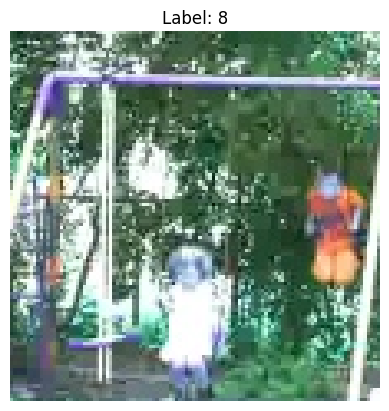

In [10]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Instantiate dataset
dataset = VideoDataset(dataset='ucf101', split='train', clip_len=16, preprocess=False, selected_classes = selected_classes)

# Create DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Sample one batch
for batch in loader:
    videos, labels = batch
    print("Video shape:", videos.shape)  # Should be [1, 3, 16, 112, 112]
    print("Label:", labels)

    # Visualize the first frame in the clip (after permuting for plotting)
    video = videos[0].permute(1, 2, 3, 0).numpy()  # [T, H, W, C]
    print(type(videos), videos.shape, videos.dtype)
    print(videos.max(), videos.min())
    # Renormalize from [0, 1] → [0, 255] for display
    video = (video * 255.0).clip(0, 255).astype(np.uint8)
    
    frame = video[0].astype(np.uint8)

    plt.imshow(frame)
    plt.title(f"Label: {labels.item()}")
    plt.axis("off")
    plt.show()
    break

In [11]:
import torch
import torch.nn as nn

class C3D(nn.Module):
    """
    The C3D network.
    """

    def __init__(self, num_classes, pretrained=False):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

        self.__init_weight()

        if pretrained:
            self.__load_pretrained_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)

        x = x.view(-1, 8192)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)

        return logits

    def __load_pretrained_weights(self):
        """Initialiaze network."""
        corresp_name = {
                        # Conv1
                        "features.0.weight": "conv1.weight",
                        "features.0.bias": "conv1.bias",
                        # Conv2
                        "features.3.weight": "conv2.weight",
                        "features.3.bias": "conv2.bias",
                        # Conv3a
                        "features.6.weight": "conv3a.weight",
                        "features.6.bias": "conv3a.bias",
                        # Conv3b
                        "features.8.weight": "conv3b.weight",
                        "features.8.bias": "conv3b.bias",
                        # Conv4a
                        "features.11.weight": "conv4a.weight",
                        "features.11.bias": "conv4a.bias",
                        # Conv4b
                        "features.13.weight": "conv4b.weight",
                        "features.13.bias": "conv4b.bias",
                        # Conv5a
                        "features.16.weight": "conv5a.weight",
                        "features.16.bias": "conv5a.bias",
                         # Conv5b
                        "features.18.weight": "conv5b.weight",
                        "features.18.bias": "conv5b.bias",
                        # fc6
                        "classifier.0.weight": "fc6.weight",
                        "classifier.0.bias": "fc6.bias",
                        # fc7
                        "classifier.3.weight": "fc7.weight",
                        "classifier.3.bias": "fc7.bias",
                        }

        p_dict = torch.load(Path.model_dir())
        s_dict = self.state_dict()
        for name in p_dict:
            if name not in corresp_name:
                continue
            s_dict[corresp_name[name]] = p_dict[name]
        self.load_state_dict(s_dict)

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def get_1x_lr_params(model):
    """
    This generator returns all the parameters for conv and two fc layers of the net.
    """
    b = [model.conv1, model.conv2, model.conv3a, model.conv3b, model.conv4a, model.conv4b,
         model.conv5a, model.conv5b, model.fc6, model.fc7]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k

def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last fc layer of the net.
    """
    b = [model.fc8]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

In [12]:
import torch
import torch.nn as nn

class HybridCNNLSTM(nn.Module):
    def __init__(self, num_classes, pretrained=False, verbose=False):
        super(HybridCNNLSTM, self).__init__()

        self.verbose = verbose
        # 3D CNN for spatial-temporal feature extraction (simplified)
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        # Add BatchNorm layers after each convolution
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3a = nn.BatchNorm3d(256)
        self.bn3b = nn.BatchNorm3d(256)
        self.bn4a = nn.BatchNorm3d(512)
        self.bn4b = nn.BatchNorm3d(512)
        
        # Calculate the feature size after CNN processing
        self.feature_size = 512 * 2 * 14 * 14  # Adjusted based on your input dimensions THIS IS NEVER USED!!
        
        # Reshape features for LSTM input
        self.lstm_input_size = 512 * 7 * 7  # Features per time step
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=512,
            num_layers=4,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        # Final classification layers
        self.fc = nn.Linear(512 * 2, num_classes)  # *2 for bidirectional
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self._initialize_weights()
        
    def forward(self, x):
        batch_size = x.size(0)
        if self.verbose:
            print(x.shape)
        # 3D CNN feature extraction
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.pool1(x)  # (1,3,,56,56)
        if self.verbose:
            print(x.shape)
            
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.pool2(x)  #(1,3,16,28,28)
        if self.verbose:
            print(x.shape)
        x = self.bn3a(self.relu(self.conv3a(x)))
        x = self.bn3b(self.relu(self.conv3b(x)))
        x = self.pool3(x)  
        if self.verbose:
            print(x.shape)

        x= self.bn4a(self.relu(self.conv4a(x)))
        x= self.bn4b(self.relu(self.conv4b(x)))
        x=self.pool4(x)
        if self.verbose:
            print(x.shape)
        # Reshape for LSTM: [batch, channels, time, height, width] -> [batch, time, features]
        x = x.permute(0, 2, 1, 3, 4)  # [batch, time, channels, height, width]
        
        time_steps = x.size(1)
        if self.verbose:
            print(x.shape)
        x = x.reshape(batch_size, time_steps, -1)  # [batch, time, features]
        if self.verbose:
            print("input to lstm")
            print(x.shape)
        # LSTM processing
        x, _ = self.lstm(x)
        if self.verbose:
            print(x.shape)
        # Take the final time step output
        x = x[:, -1, :]
        
        # Classification
        x = self.dropout(x)
        x = self.fc(x)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

In [13]:
inputs = torch.rand(1, 3, 16, 112, 112)
net = HybridCNNLSTM(num_classes=10, pretrained=False)

outputs = net.forward(inputs)
print(outputs.size())

torch.Size([1, 10])


In [14]:
def get_class_names(dataset_path, selected_classes=None):
    """Get class names from the dataset directory."""
    train_dir = os.path.join(dataset_path, 'train')
    
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Train directory not found: {train_dir}")
    
    all_classes = sorted(os.listdir(train_dir))
    
    if selected_classes is not None:
        # Filter classes to only include selected ones
        class_names = [cls for cls in all_classes if cls in selected_classes]
        if not class_names:
            raise ValueError("None of the selected classes were found in the dataset.")
    else:
        class_names = all_classes
        
    return class_names


def evaluate_model(model, test_dataloader, device, criterion, class_names):
    """Evaluate the model on the test set and calculate metrics."""
    model.eval()
    start_time = timeit.default_timer()
    
    # Initialize metrics
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Evaluation loop
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate probabilities
            probs = nn.Softmax(dim=1)(outputs)
            all_probs.extend(probs.cpu().numpy())
            
            # Get predictions
            preds = torch.max(probs, 1)[1]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    
    # Calculate overall metrics
    test_size = len(test_dataloader.dataset)
    loss = running_loss / test_size
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Calculate F1, precision, and recall scores
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Execution time
    stop_time = timeit.default_timer()
    execution_time = stop_time - start_time
    
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'execution_time': execution_time,
        'all_probs': np.array(all_probs),
        'all_preds': all_preds,
        'all_labels': all_labels
    }
    
    return metrics


def plot_confusion_matrix(conf_matrix, class_names, output_path="confusion_matrix.png"):
    """Plot the confusion matrix as a heatmap."""
    plt.figure(figsize=(12, 10))
    
    # Normalize confusion matrix
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Create a heatmap
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_metrics_by_class(report, class_names, output_path="class_metrics.png"):
    """Plot precision, recall, and F1-score for each class."""
    # Extract class metrics
    metrics_df = pd.DataFrame({
        'Precision': [report[class_name]['precision'] for class_name in class_names],
        'Recall': [report[class_name]['recall'] for class_name in class_names],
        'F1-Score': [report[class_name]['f1-score'] for class_name in class_names]
    }, index=class_names)
    
    # Plot
    plt.figure(figsize=(14, 8))
    metrics_df.plot(kind='bar', rot=45)
    plt.title('Performance Metrics by Class')
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def print_metrics_summary(metrics, class_names):
    """Print a summary of the evaluation metrics."""
    print("\n" + "="*50)
    print("MODEL EVALUATION SUMMARY")
    print("="*50)
    
    print(f"Test Loss: {metrics['loss']:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"F1 Score (Weighted): {metrics['f1_score']:.4f}")
    print(f"Precision (Weighted): {metrics['precision']:.4f}")
    print(f"Recall (Weighted): {metrics['recall']:.4f}")
    print(f"Execution Time: {metrics['execution_time']:.2f} seconds")
    
    # Print per-class metrics
    print("\nPer-Class Metrics:")
    print("-"*50)
    report = metrics['classification_report']
    for class_name in class_names:
        print(f"{class_name}:")
        print(f"  Precision: {report[class_name]['precision']:.4f}")
        print(f"  Recall: {report[class_name]['recall']:.4f}")
        print(f"  F1-Score: {report[class_name]['f1-score']:.4f}")
        print(f"  Support: {report[class_name]['support']}")
        print()


def save_metrics_to_csv(metrics, class_names, output_path="model_evaluation_results.csv"):
    """Save the evaluation metrics to a CSV file."""
    # Overall metrics
    overall_metrics = {
        'Metric': ['Loss', 'Accuracy', 'F1 Score (Weighted)', 'Precision (Weighted)', 'Recall (Weighted)'],
        'Value': [
            metrics['loss'],
            metrics['accuracy'],
            metrics['f1_score'],
            metrics['precision'],
            metrics['recall']
        ]
    }
    
    overall_df = pd.DataFrame(overall_metrics)
    
    # Per-class metrics
    class_metrics = []
    report = metrics['classification_report']
    
    for class_name in class_names:
        class_metrics.append({
            'Class': class_name,
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'F1-Score': report[class_name]['f1-score'],
            'Support': report[class_name]['support']
        })
    
    class_df = pd.DataFrame(class_metrics)
    
    # Save to CSV
    with open(output_path, 'w') as f:
        f.write("OVERALL METRICS\n")
        overall_df.to_csv(f, index=False)
        f.write("\nPER-CLASS METRICS\n")
        class_df.to_csv(f, index=False)
    
    print(f"\nMetrics saved to {output_path}")

In [15]:
# os.listdir("/kaggle/working/save_dir/run/run_0/models")

In [16]:
# Use GPU if available else revert to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

nEpochs = 50  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume
useTest = True # See evolution of the test set when training
nTestInterval = 5 # Run on test set every nTestInterval epochs
snapshot = 5 # Store a model every snapshot epochs
lr = 1e-4 # Learning rate

dataset = 'ucf101' # Options: hmdb51 or ucf101

if dataset == 'hmdb51':
    num_classes=51
elif dataset == 'ucf101':
    num_classes = 101
else:
    print('We only implemented hmdb and ucf datasets.')
    raise NotImplementedError


save_dir_root = "/kaggle/working/save_dir"
if not os.path.exists(save_dir_root):
    os.mkdir(save_dir_root)
# save_dir_root = os.path.join(os.path.dirname(os.path.abspath(__file__)))
# exp_name = os.path.dirname(os.path.abspath(__file__)).split('/')[-1]

if resume_epoch != 0:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) if runs else 0
else:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) + 1 if runs else 0

save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))
modelName = 'HybridCNNLSTM' # Options: C3D or R2Plus1D or R3D

model = HybridCNNLSTM(num_classes = len(selected_classes), pretrained=False)

saveName = modelName + '-' + dataset

Device being used: cuda


In [17]:
def train_model(model, dataset=dataset, save_dir=save_dir, num_classes=num_classes, lr=lr,
                num_epochs=nEpochs, save_epoch=snapshot, useTest=useTest, test_interval=nTestInterval):
    """
        Args:
            num_classes (int): Number of classes in the data
            num_epochs (int, optional): Number of epochs to train for.
    """

    # if modelName == 'C3D':
    #     model = C3D(num_classes=num_classes, pretrained=False)
    #     train_params = [{'params': get_1x_lr_params(model), 'lr': lr},
    #                     {'params': get_10x_lr_params(model), 'lr': lr * 10}]
    # elif modelName == 'R2Plus1D':
    #     model = R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    #     train_params = [{'params': get_1x_lr_params(model), 'lr': lr},
    #                     {'params': get_10x_lr_params(model), 'lr': lr * 10}]
    # elif modelName == 'R3D':
    #     model = R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    #     train_params = model.parameters()
    # else:
    #     print('We only implemented C3D and R2Plus1D models.')
    #     raise NotImplementedError

    train_params = model.parameters()
    
    criterion = nn.CrossEntropyLoss()  # standard crossentropy loss for classification
    optimizer = optim.Adam(train_params, lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                          gamma=0.1)  # the scheduler divides the lr by 10 every 10 epochs

    if resume_epoch == 0:
        print("Training {} from scratch...".format(modelName))
    else:
        checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'),
                       map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
        print("Initializing weights from: {}...".format(
            os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['opt_dict'])

    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    model.to(device)
    criterion.to(device)

    log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
    writer = SummaryWriter(log_dir=log_dir)

    print('Training model on {} dataset...'.format(dataset))
    train_dataloader = DataLoader(VideoDataset(dataset=dataset, split='train',clip_len=16, selected_classes = selected_classes), batch_size=20, shuffle=True, num_workers=4)
    val_dataloader   = DataLoader(VideoDataset(dataset=dataset, split='val',  clip_len=16,selected_classes = selected_classes), batch_size=20, num_workers=4)
    test_dataloader  = DataLoader(VideoDataset(dataset=dataset, split='test', clip_len=16,selected_classes = selected_classes), batch_size=20, num_workers=4)

    trainval_loaders = {'train': train_dataloader, 'val': val_dataloader}
    trainval_sizes = {x: len(trainval_loaders[x].dataset) for x in ['train', 'val']}
    test_size = len(test_dataloader.dataset)

    for epoch in range(resume_epoch, num_epochs):
        # each epoch has a training and validation step
        for phase in ['train']:
            start_time = timeit.default_timer()

            # reset the running loss and corrects
            running_loss = 0.0
            running_corrects = 0.0

            # set model to train() or eval() mode depending on whether it is trained
            # or being validated. Primarily affects layers such as BatchNorm or Dropout.
            if phase == 'train':
                # scheduler.step() is to be called once every epoch during training
                scheduler.step()
                model.train()
            else:
                model.eval()

            for inputs, labels in tqdm(trainval_loaders[phase]):
                # move inputs and labels to the device the training is taking place on
                inputs = Variable(inputs, requires_grad=True).to(device)
                # print("Inputs max:", inputs.max(), "min:", inputs.min())
                # print("Labels unique:", labels.unique())

                labels = Variable(labels).to(device)
                optimizer.zero_grad()

                if phase == 'train':
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)

                # probs = nn.Softmax(dim=1)(outputs)
                # preds = torch.max(probs, 1)[1]
                # loss = criterion(outputs, labels)
                loss = criterion(outputs, labels)
                preds = torch.max(outputs, 1)[1]

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / trainval_sizes[phase]
            epoch_acc = running_corrects.double() / trainval_sizes[phase]

            if phase == 'train':
                writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
                writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
            else:
                writer.add_scalar('data/val_loss_epoch', epoch_loss, epoch)
                writer.add_scalar('data/val_acc_epoch', epoch_acc, epoch)

            print("[{}] Epoch: {}/{} Loss: {} Acc: {}".format(phase, epoch+1, nEpochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

        if epoch % save_epoch == (save_epoch - 1):
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'opt_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
            print("Save model at {}\n".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar')))

        if useTest and epoch % test_interval == (test_interval - 1):
            model.eval()
            start_time = timeit.default_timer()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                probs = nn.Softmax(dim=1)(outputs)
                preds = torch.max(probs, 1)[1]
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / test_size
            epoch_acc = running_corrects.double() / test_size

            writer.add_scalar('data/test_loss_epoch', epoch_loss, epoch)
            writer.add_scalar('data/test_acc_epoch', epoch_acc, epoch)

            print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

    metrics = evaluate_model(model, test_dataloader, device, criterion, class_names = selected_classes)
    # Print results summary
    print_metrics_summary(metrics, class_names = selected_classes)

    cm_path = os.path.join("kaggle/working", "confusion_matrix.png")
    plot_confusion_matrix(metrics['confusion_matrix'], selected_classes, cm_path)
    metrics_path = os.path.join("kaggle/working/", "class_metrics.png")
    plot_metrics_by_class(metrics['classification_report'], selected_classes, metrics_path)
    
    writer.close()

Training HybridCNNLSTM from scratch...
Total params: 137.28M
Training model on ucf101 dataset...
Using 10 selected classes out of 101 available classes.
Number of train videos: 802
Using 10 selected classes out of 101 available classes.
Number of val videos: 204


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Using 10 selected classes out of 101 available classes.
Number of test videos: 256


100%|██████████| 41/41 [01:03<00:00,  1.54s/it]


[train] Epoch: 1/50 Loss: 2.2815833983575913 Acc: 0.2082294264339152
Execution time: 63.24286654599996



100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


[train] Epoch: 2/50 Loss: 1.9764772252251679 Acc: 0.2793017456359102
Execution time: 42.79852576500002



100%|██████████| 41/41 [00:48<00:00,  1.18s/it]


[train] Epoch: 3/50 Loss: 1.6653294191693426 Acc: 0.37531172069825436
Execution time: 48.34697630300002



100%|██████████| 41/41 [00:44<00:00,  1.09s/it]


[train] Epoch: 4/50 Loss: 1.3636283226441266 Acc: 0.45261845386533667
Execution time: 44.868508807000126



100%|██████████| 41/41 [00:46<00:00,  1.14s/it]


[train] Epoch: 5/50 Loss: 1.2626940564918994 Acc: 0.5236907730673317
Execution time: 46.61563021999996

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-4.pth.tar



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


[test] Epoch: 5/50 Loss: 1.2471228269860148 Acc: 0.55078125
Execution time: 26.204115799999954



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 6/50 Loss: 1.140751837494962 Acc: 0.5935162094763092
Execution time: 42.23085419500012



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 7/50 Loss: 1.045196322728868 Acc: 0.6596009975062344
Execution time: 42.10932219899996



100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


[train] Epoch: 8/50 Loss: 1.01123209279077 Acc: 0.6546134663341646
Execution time: 42.80659077699988



100%|██████████| 41/41 [00:48<00:00,  1.19s/it]


[train] Epoch: 9/50 Loss: 0.9061785016273917 Acc: 0.7019950124688279
Execution time: 48.764690912000106



100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


[train] Epoch: 10/50 Loss: 0.7350547735827819 Acc: 0.7768079800498753
Execution time: 43.531267814999865

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-9.pth.tar



100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


[test] Epoch: 10/50 Loss: 0.8234001881210133 Acc: 0.734375
Execution time: 17.45145261100015



100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


[train] Epoch: 11/50 Loss: 0.6711501862640096 Acc: 0.8029925187032418
Execution time: 43.62817215299992



100%|██████████| 41/41 [00:47<00:00,  1.15s/it]


[train] Epoch: 12/50 Loss: 0.6139313596442453 Acc: 0.8254364089775561
Execution time: 47.266211442999975



100%|██████████| 41/41 [00:44<00:00,  1.10s/it]


[train] Epoch: 13/50 Loss: 0.5792831668532697 Acc: 0.8192019950124688
Execution time: 45.004022115000225



100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


[train] Epoch: 14/50 Loss: 0.5533592988205075 Acc: 0.8478802992518703
Execution time: 43.285135375999744



100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


[train] Epoch: 15/50 Loss: 0.5295770310998855 Acc: 0.8528678304239401
Execution time: 43.526380774000245

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-14.pth.tar



100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


[test] Epoch: 15/50 Loss: 0.6591044736560434 Acc: 0.79296875
Execution time: 8.417986574000224



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 16/50 Loss: 0.5052553338005655 Acc: 0.8528678304239401
Execution time: 42.22419102599997



100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


[train] Epoch: 17/50 Loss: 0.4965628751198253 Acc: 0.8640897755610972
Execution time: 45.18893423999998



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 18/50 Loss: 0.4521420123496852 Acc: 0.8628428927680798
Execution time: 42.05838077599992



100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


[train] Epoch: 19/50 Loss: 0.45958706112276587 Acc: 0.8827930174563591
Execution time: 42.57761734699989



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 20/50 Loss: 0.43264462287883804 Acc: 0.8765586034912718
Execution time: 42.254362686999684

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-19.pth.tar



100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


[test] Epoch: 20/50 Loss: 0.5725479969987646 Acc: 0.83203125
Execution time: 8.821640787999968



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 21/50 Loss: 0.4226200929157752 Acc: 0.8940149625935162
Execution time: 42.41433775099995



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 22/50 Loss: 0.4275121458450755 Acc: 0.8952618453865336
Execution time: 42.20758656599992



100%|██████████| 41/41 [00:43<00:00,  1.05s/it]


[train] Epoch: 23/50 Loss: 0.45240634984506334 Acc: 0.8628428927680798
Execution time: 43.04039297999998



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 24/50 Loss: 0.4017769654938705 Acc: 0.8915211970074812
Execution time: 42.295263892000094



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


[train] Epoch: 25/50 Loss: 0.4049546801092619 Acc: 0.8965087281795511
Execution time: 41.97904494000022

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-24.pth.tar



100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


[test] Epoch: 25/50 Loss: 0.5907252595061436 Acc: 0.83203125
Execution time: 8.565003710999918



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 26/50 Loss: 0.42779548217233576 Acc: 0.8827930174563591
Execution time: 42.335896119000154



100%|██████████| 41/41 [00:42<00:00,  1.02s/it]


[train] Epoch: 27/50 Loss: 0.43713162642464676 Acc: 0.8852867830423939
Execution time: 42.01902659000007



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 28/50 Loss: 0.4140224777106335 Acc: 0.8865336658354115
Execution time: 42.086285484999735



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


[train] Epoch: 29/50 Loss: 0.43564474664424124 Acc: 0.8740648379052369
Execution time: 41.87048567800002



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


[train] Epoch: 30/50 Loss: 0.4301007281515069 Acc: 0.8865336658354115
Execution time: 41.94227221900019

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-29.pth.tar



100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


[test] Epoch: 30/50 Loss: 0.5794177640345879 Acc: 0.83203125
Execution time: 8.257760594999581



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 31/50 Loss: 0.40629654595084913 Acc: 0.8827930174563591
Execution time: 42.202880011999696



100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


[train] Epoch: 32/50 Loss: 0.4183756587214006 Acc: 0.8902743142144638
Execution time: 43.46568199100011



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 33/50 Loss: 0.42710314620462736 Acc: 0.8890274314214464
Execution time: 42.1689807810003



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 34/50 Loss: 0.4206277817264757 Acc: 0.8965087281795511
Execution time: 42.06020195700012



100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


[train] Epoch: 35/50 Loss: 0.39132917960385727 Acc: 0.9064837905236908
Execution time: 42.45477388399968

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-34.pth.tar



100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


[test] Epoch: 35/50 Loss: 0.5548174576833844 Acc: 0.83984375
Execution time: 10.696892728999956



100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


[train] Epoch: 36/50 Loss: 0.39787847197561194 Acc: 0.8977556109725685
Execution time: 43.396630002000165



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 37/50 Loss: 0.4207224252348083 Acc: 0.8890274314214464
Execution time: 42.410768353000094



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 38/50 Loss: 0.4128955355903454 Acc: 0.8965087281795511
Execution time: 42.10942876699983



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 39/50 Loss: 0.39307200358692845 Acc: 0.8940149625935162
Execution time: 42.10277360100008



100%|██████████| 41/41 [00:48<00:00,  1.18s/it]


[train] Epoch: 40/50 Loss: 0.4201077089048086 Acc: 0.8927680798004988
Execution time: 48.493449892999706

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-39.pth.tar



100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


[test] Epoch: 40/50 Loss: 0.5578194045228884 Acc: 0.82421875
Execution time: 9.084336068000084



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 41/50 Loss: 0.4255483450735002 Acc: 0.8940149625935162
Execution time: 42.20960511999965



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


[train] Epoch: 42/50 Loss: 0.3928239447368945 Acc: 0.8952618453865336
Execution time: 42.17940038400002



100%|██████████| 41/41 [00:51<00:00,  1.25s/it]


[train] Epoch: 43/50 Loss: 0.40910064824798753 Acc: 0.8915211970074812
Execution time: 51.10376336799982



100%|██████████| 41/41 [00:50<00:00,  1.22s/it]


[train] Epoch: 44/50 Loss: 0.4270101878559798 Acc: 0.8877805486284289
Execution time: 50.10532023799988



100%|██████████| 41/41 [01:03<00:00,  1.54s/it]


[train] Epoch: 45/50 Loss: 0.47330188780948707 Acc: 0.8591022443890274
Execution time: 63.31489818

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-44.pth.tar



100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


[test] Epoch: 45/50 Loss: 0.6149704279960133 Acc: 0.82421875
Execution time: 18.559233398000288



100%|██████████| 41/41 [00:47<00:00,  1.17s/it]


[train] Epoch: 46/50 Loss: 0.4265157895492497 Acc: 0.8915211970074812
Execution time: 47.99814953300029



100%|██████████| 41/41 [00:49<00:00,  1.20s/it]


[train] Epoch: 47/50 Loss: 0.40470654541566187 Acc: 0.8927680798004988
Execution time: 49.08228533900001



100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


[train] Epoch: 48/50 Loss: 0.391773509637376 Acc: 0.9039900249376558
Execution time: 43.68615070399983



100%|██████████| 41/41 [00:46<00:00,  1.13s/it]


[train] Epoch: 49/50 Loss: 0.3964089757932392 Acc: 0.899002493765586
Execution time: 46.294436978999784



100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


[train] Epoch: 50/50 Loss: 0.43256360426210705 Acc: 0.899002493765586
Execution time: 42.7446365640003

Save model at /kaggle/working/save_dir/run/run_0/models/HybridCNNLSTM-ucf101_epoch-49.pth.tar



100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


[test] Epoch: 50/50 Loss: 0.6623418685048819 Acc: 0.78515625
Execution time: 8.583696606000103



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]



MODEL EVALUATION SUMMARY
Test Loss: 0.6129
Test Accuracy: 0.8086 (80.86%)
F1 Score (Weighted): 0.8053
Precision (Weighted): 0.8118
Recall (Weighted): 0.8086
Execution Time: 8.77 seconds

Per-Class Metrics:
--------------------------------------------------
PlayingPiano:
  Precision: 0.7083
  Recall: 0.6296
  F1-Score: 0.6667
  Support: 27

TaiChi:
  Precision: 0.8571
  Recall: 1.0000
  F1-Score: 0.9231
  Support: 30

Swing:
  Precision: 0.7692
  Recall: 0.8696
  F1-Score: 0.8163
  Support: 23

HorseRace:
  Precision: 0.7200
  Recall: 0.7200
  F1-Score: 0.7200
  Support: 25

PlayingTabla:
  Precision: 0.7273
  Recall: 0.8571
  F1-Score: 0.7869
  Support: 28

Mixing:
  Precision: 1.0000
  Recall: 0.8095
  F1-Score: 0.8947
  Support: 21

Fencing:
  Precision: 0.7407
  Recall: 0.8696
  F1-Score: 0.8000
  Support: 23

Basketball:
  Precision: 0.9688
  Recall: 0.9688
  F1-Score: 0.9688
  Support: 32

Punch:
  Precision: 0.9091
  Recall: 0.7407
  F1-Score: 0.8163
  Support: 27

Diving:
  Pre

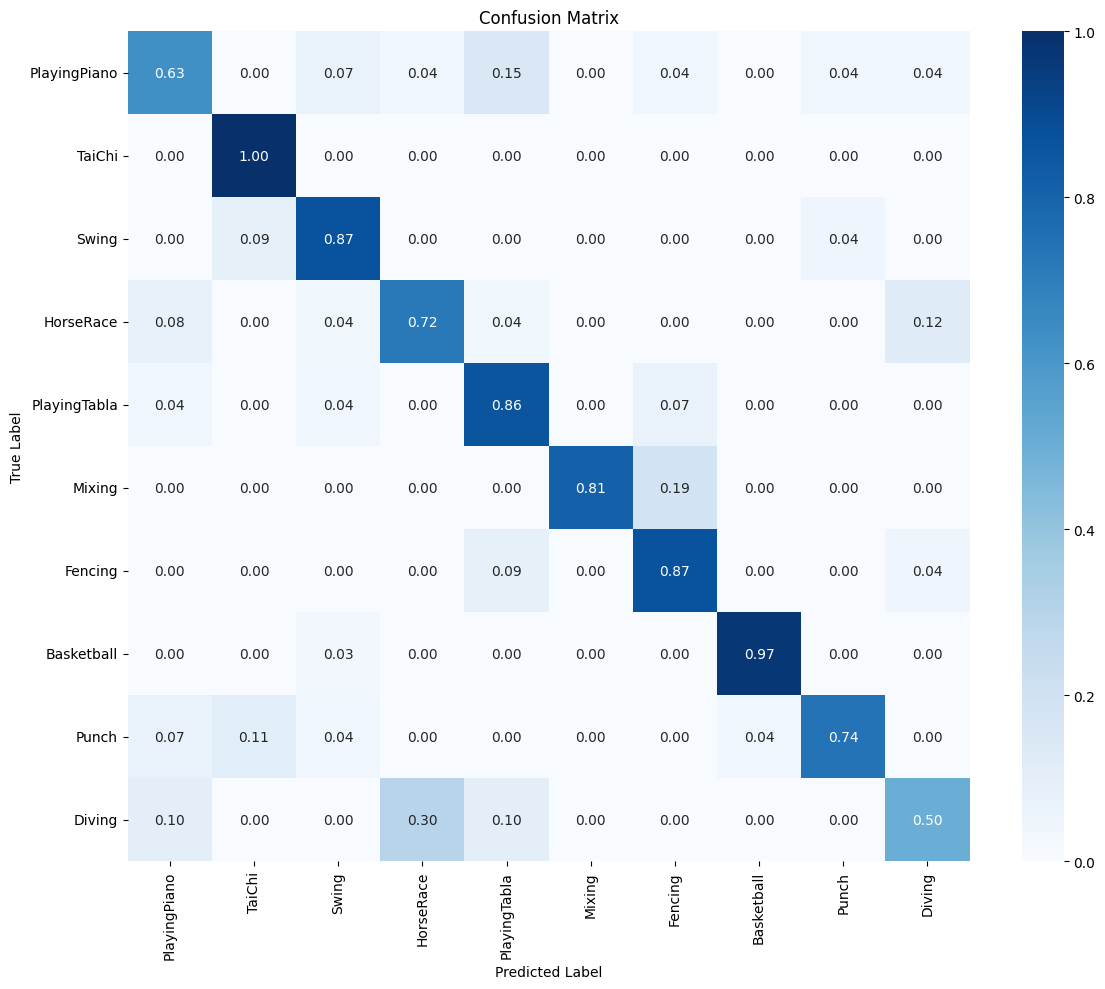

<Figure size 1400x800 with 0 Axes>

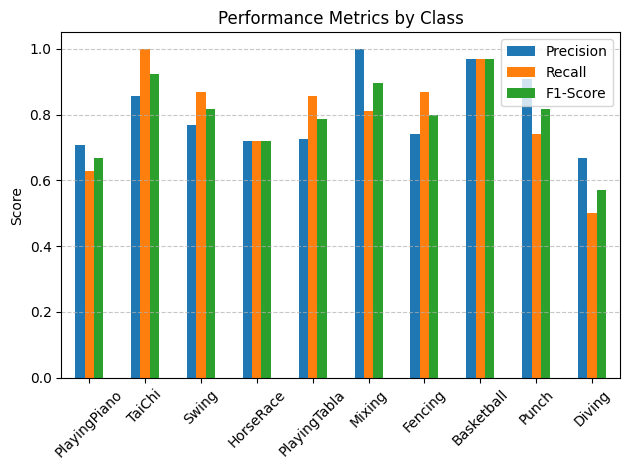

In [18]:
train_model(model, num_epochs = nEpochs)

In [19]:
# !tensorboard --logdir=/kaggle/working/save_dir/run/run_2/models/Apr25_19-00-55_e8a416e980c9

In [20]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import matplotlib.pyplot as plt
import glob
from datetime import datetime

In [21]:
# Load extension
%load_ext tensorboard

In [22]:
# os.listdir("/kaggle/working/save_dir/run/run_1/models/Apr29_09-07-19_dfd9a178798b")

In [23]:
def find_latest_run(base_dir="/kaggle/working/save_dir/run"):
    """Find the latest run directory based on timestamp in folder name."""
    # Find all run directories
    run_dirs = glob.glob(os.path.join(base_dir, "run_*"))
    
    if not run_dirs:
        raise FileNotFoundError(f"No run directories found in {base_dir}")
    
    # If there's only one run directory, use it
    if len(run_dirs) == 1:
        latest_run = run_dirs[0]
    else:
        # If there are multiple, find the latest one based on directory name
        # Assuming directory names include run_1, run_2, etc.
        latest_run = max(run_dirs, key=lambda x: int(os.path.basename(x).split('_')[1]))
    
    return latest_run

In [24]:
def find_latest_event_file(run_dir):
    """Find the latest event file within the models directory."""
    # Find all models directories (they should contain date-based names)
    model_dirs = glob.glob(os.path.join(run_dir, "models", "*"))
    
    if not model_dirs:
        raise FileNotFoundError(f"No model directories found in {run_dir}/models")
    
    # Extract timestamps from directory names
    # Assuming format like Apr29_09-07-19_dfd9a178798b
    latest_model_dir = None
    latest_timestamp = None
    
    for model_dir in model_dirs:
        dir_name = os.path.basename(model_dir)
        if '_' in dir_name:
            try:
                # Parse the date part (e.g., Apr29_09-07-19)
                date_str = '_'.join(dir_name.split('_')[:2])
                timestamp = datetime.strptime(date_str, "%b%d_%H-%M-%S")
                
                if latest_timestamp is None or timestamp > latest_timestamp:
                    latest_timestamp = timestamp
                    latest_model_dir = model_dir
            except (ValueError, IndexError):
                # If parsing fails, continue to the next directory
                continue
    
    if latest_model_dir is None:
        # If timestamp-based approach failed, just take the most recently modified directory
        latest_model_dir = max(model_dirs, key=os.path.getmtime)
    
    # Find event file in the latest model directory
    event_files = glob.glob(os.path.join(latest_model_dir, "events.out.tfevents.*"))
    
    if not event_files:
        raise FileNotFoundError(f"No event files found in {latest_model_dir}")
    
    # If multiple event files exist, take the most recent one
    latest_event_file = max(event_files, key=os.path.getmtime)
    
    return latest_event_file

In [25]:
def plot_tensorboard_metrics(event_file):
    """Plot accuracy and loss curves from TensorBoard events file."""
    # Tags for metrics to extract
    accuracy_tags = ['data/train_acc_epoch', 'data/val_acc_epoch', 'data/test_acc_epoch']
    loss_tags = ['data/train_loss_epoch', 'data/val_loss_epoch', 'data/test_loss_epoch']
    
    # Load events
    ea = EventAccumulator(event_file)
    ea.Reload()  # Load everything
    
    available_tags = ea.Tags()['scalars']
    print(f"Available tags: {available_tags}")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot accuracy curves
    ax1.set_title('Accuracy Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    
    for tag in accuracy_tags:
        if tag in available_tags:
            events = ea.Scalars(tag)
            steps = [e.step for e in events]
            values = [e.value for e in events]
            label = tag.split('/')[-1].replace('_epoch', '').capitalize()
            ax1.plot(steps, values, marker='o', label=label)
        else:
            print(f"Tag not found: {tag}")
    
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss curves
    ax2.set_title('Loss Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    
    for tag in loss_tags:
        if tag in available_tags:
            events = ea.Scalars(tag)
            steps = [e.step for e in events]
            values = [e.value for e in events]
            label = tag.split('/')[-1].replace('_epoch', '').capitalize()
            ax2.plot(steps, values, marker='o', label=label)
        else:
            print(f"Tag not found: {tag}")
    
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

Found latest run directory: /kaggle/working/save_dir/run/run_0
Found latest event file: /kaggle/working/save_dir/run/run_0/models/Apr29_17-15-26_8fcc88bcab94/events.out.tfevents.1745946926.8fcc88bcab94


2025-04-29 17:55:34.056918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745949334.272462      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745949334.335442      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Available tags: ['data/train_loss_epoch', 'data/train_acc_epoch', 'data/test_loss_epoch', 'data/test_acc_epoch']
Tag not found: data/val_acc_epoch
Tag not found: data/val_loss_epoch


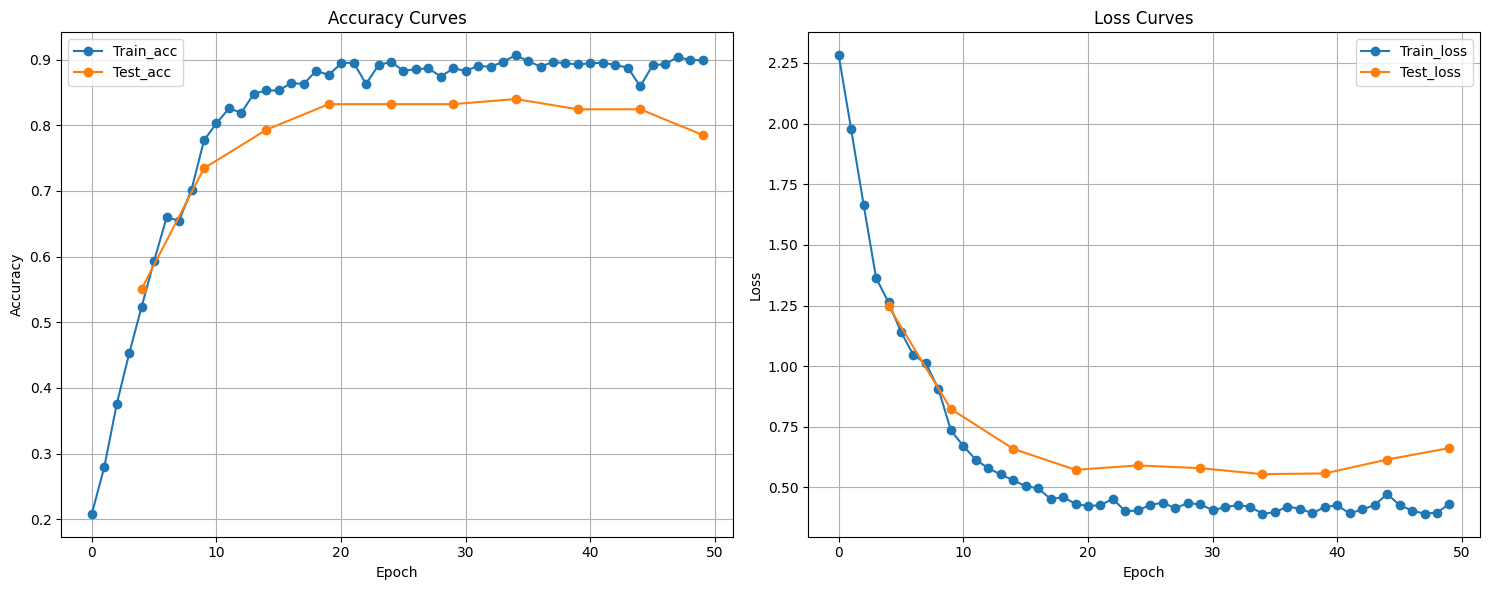

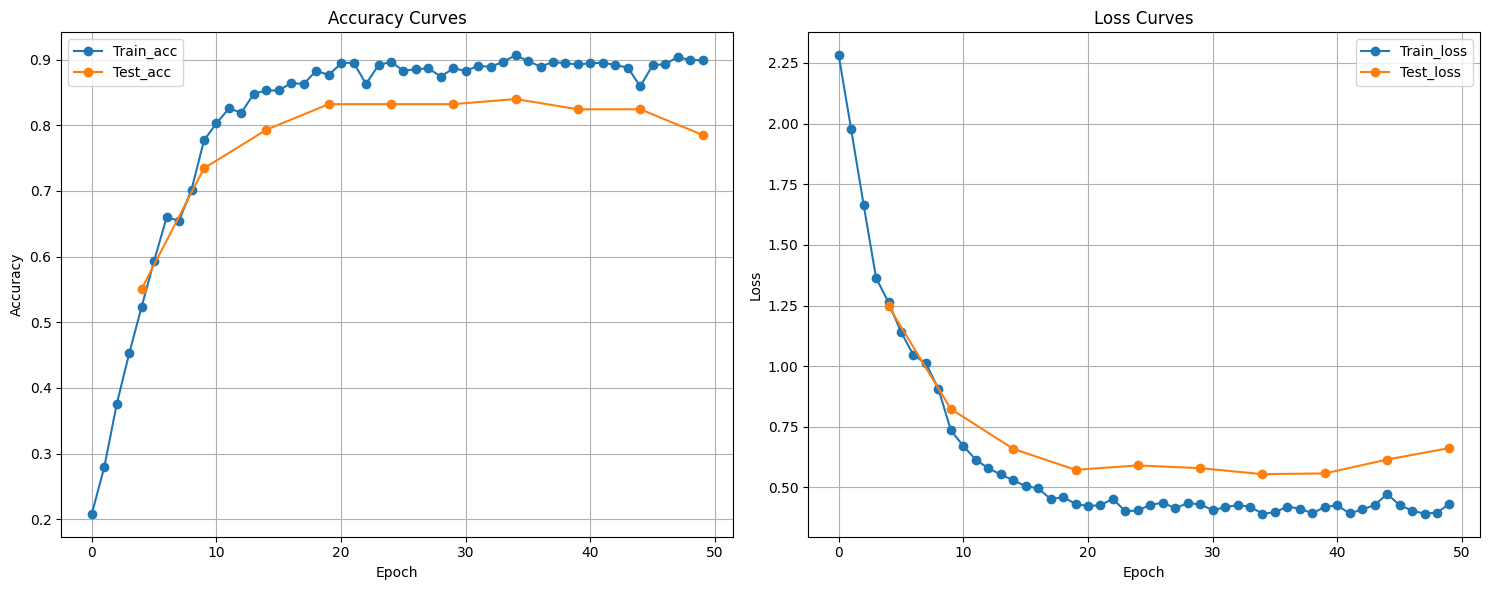

In [26]:
# Find the latest run directory
latest_run = find_latest_run()
print(f"Found latest run directory: {latest_run}")

# Find the latest event file
latest_event_file = find_latest_event_file(latest_run)
print(f"Found latest event file: {latest_event_file}")

# Plot the metrics
plot_tensorboard_metrics(latest_event_file)